In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
#from patsy import dmatrices
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
f = r'C:\Users\Josè Valencia\Desktop\Python\RStudio\baseFREQ.csv'

# Exercises of python

In [3]:
df = pd.read_csv(f, sep=';', encoding='unicode_escape', index_col=0)

In [18]:
df.sexe = np.where(df.sexe=='M',1,0)
df.presence_alarme = np.where(df.presence_alarme=='oui',1,0)
df.freq_paiement = np.where(df.freq_paiement=='annuel',1,0)
df.langue = np.where(df.langue=='A',1,0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39075 entries, 1 to 39075
Data columns (total 14 columns):
freq_paiement      39075 non-null int32
langue             39075 non-null int32
type_prof          39075 non-null object
alimentation       39075 non-null object
type_territoire    39075 non-null object
utilisation        39075 non-null object
presence_alarme    39075 non-null int32
marque_voiture     39075 non-null object
sexe               39075 non-null int32
nbsin              39075 non-null int64
exposition         39075 non-null object
cout               39075 non-null float64
age                39075 non-null int64
duree_permis       39075 non-null int64
dtypes: float64(1), int32(4), int64(3), object(6)
memory usage: 3.9+ MB


In [19]:
df.head()

,freq_paiement,langue,type_prof,alimentation,type_territoire,utilisation,presence_alarme,marque_voiture,sexe,nbsin,exposition,cout,age,duree_permis
numeropol,,,,,,,,,,,,,,
1,0,0,Technicien,Végétarien,Urbain,Travail-quotidien,0,VOLKSWAGEN,0,0,0.610958904,0.00,29,10
2,0,0,Technicien,Végétarien,Urbain,Travail-quotidien,0,VOLKSWAGEN,0,0,0.663013699,0.00,30,11
3,1,1,Technicien,Carnivore,Urbain,Travail-occasionnel,1,NISSAN,1,1,0.994520548,279.58,42,21
4,1,1,Technicien,Carnivore,Urbain,Travail-occasionnel,1,NISSAN,1,0,0.873972603,0.00,43,22
5,1,1,Technicien,Carnivore,Urbain,Travail-occasionnel,1,NISSAN,1,0,0.043835616,0.00,44,23


In [7]:
df.age.describe()

count    39075.000000
mean        45.590633
std         12.057312
min         18.000000
25%         36.000000
50%         44.000000
75%         54.000000
max         87.000000
Name: age, dtype: float64

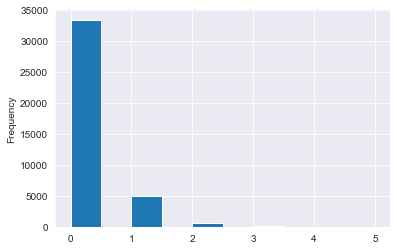

In [21]:
df.nbsin.plot(kind='hist')

In [19]:
df.nbsin.value_counts()

0    33386
1     4957
2      646
3       78
4        7
5        1
Name: nbsin, dtype: int64

In [20]:
sps.describe(df.nbsin)

DescribeResult(nobs=39075, minmax=(0, 5), mean=0.16675623800383876, variance=0.1866565069654242, skewness=2.8480374597268714, kurtosis=9.33716281451126)

In [6]:
df.cout.describe()

count     39075.000000
mean       1326.171073
std       12934.046195
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      665751.990000
Name: cout, dtype: float64

In [122]:
pdf1 = sps.lognorm.pdf(x, f1[0], f1[1], f1[2])

In [35]:
def standarise(column,pct,pct_lower):
    sc = StandardScaler()
    y = df[column][df[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y

In [36]:
def fit_distribution(column, pct, pct_lower):
    # Set up list of candidate distributions to use
    # See https://docs.scipy.org/doc/scipy/reference/stats.html for more
    y_std, size, y_org = standarise(column, pct, pct_lower)
    dist_names = ['weibull_min', 'norm', 'weibull_max', 'beta',
                  'invgauss', 'uniform', 'gamma', 'expon', 'lognorm', 'pearson3', 'triang']

    chi_square_statistics = []
    # 11 bins
    percentile_bins = np.linspace(0, 100, 11)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)
        print("{}\n{}\n".format(dist, param))

        # Get expected counts in percentile bins
        # cdf of fitted sistrinution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins) - 1):
            expected_cdf_area = cdf_fitted[bin + 1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = round(sum(((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency), 0)
        chi_square_statistics.append(ss)

    # Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results.sort_values(['chi_square'], inplace=True)

    print('\nDistributions listed by Betterment of fit:')
    print('............................................')
    print(results)

In [39]:
fit_distribution('duree_permis', 0.99, 0.01)

(3.6483742552437706, -3.185395240596659, 3.5418580774481914)

(-1.4250191180439675e-16, 1.0)

(2.729572490823182, 2.4955450404036466, 2.809904017516832)

(2.111096626853681, 2.253019244771612, -2.2492253592357696, 4.615281268887337)

(0.023185294014503158, -6.878121112273135, 296.0143502928919)

(-2.101158898170456, 4.414906044707897)

(515.7002237701972, -22.81547724885162, 0.0442420808291398)

(-2.101158898170456, 2.101158898170456)

(0.009338933962167888, -107.1446875040312, 107.14595133001671)

(-0.4313326970982095, -2.584994653947001e-16, 1.0098529799678935)

(0.5518664480277564, -2.3959903911067304, 4.7447462584924995)


Distributions listed by Betterment of fit:
............................................
   Distribution  chi_square
10       triang       754.0
3          beta       768.0
2   weibull_max      1030.0
0   weibull_min      1113.0
6         gamma      1262.0
1          norm      1270.0
8       lognorm      1286.0
4      invgauss      1689.0
5       uniform      4439

In [140]:
y_std,len_y,y = standarise('age',0.99,0.01)

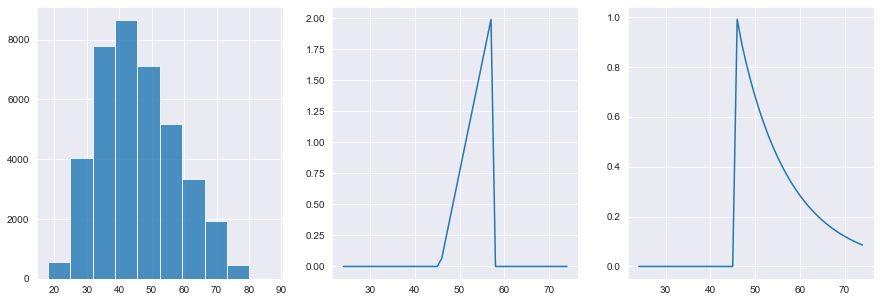

In [156]:
plt.rcParams['figure.figsize'] = [15,5]
plt.subplot(1,3,1)
plt.hist(df.age, alpha=0.8)
plt.subplot(1,3,2)
plt.plot(y, triang.pdf(y_std, 0.99, 0.01))
plt.subplot(1,3,3)
plt.plot(y, weibull_min.pdf(y_std, 0.99, 0.01))
plt.show()

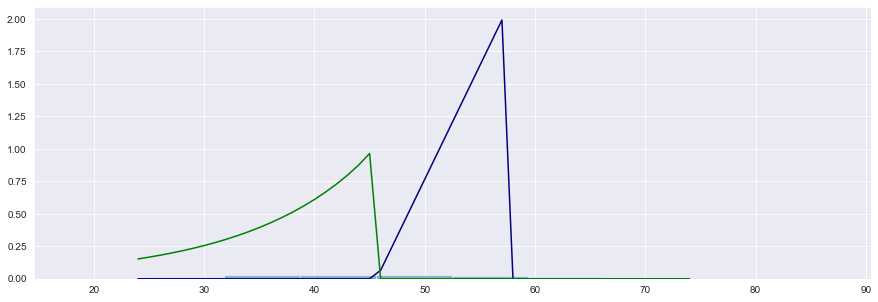

In [143]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.hist(df.age, density=True, alpha=0.5)
plt.plot(y, triang.pdf(y_std, 0.99, 0.01), label='Triang', color='navy')
plt.plot(y, weibull_max.pdf(y_std, 0.99, 0.01), label='Weibull', color='green')
plt.show()

In [13]:
df.cout = np.log(df.cout+1)
df.cout.head()

numeropol
1    0.000000
2    0.000000
3    5.636859
4    0.000000
5    0.000000
Name: cout, dtype: float64

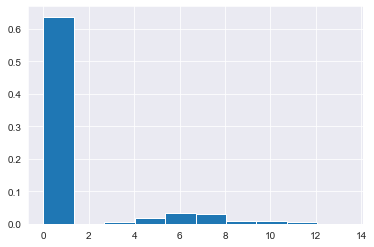

In [14]:
plt.hist(df.cout, density=True)
plt.show()

In [150]:
x = np.linspace(0, np.max(df.cout), 1000)

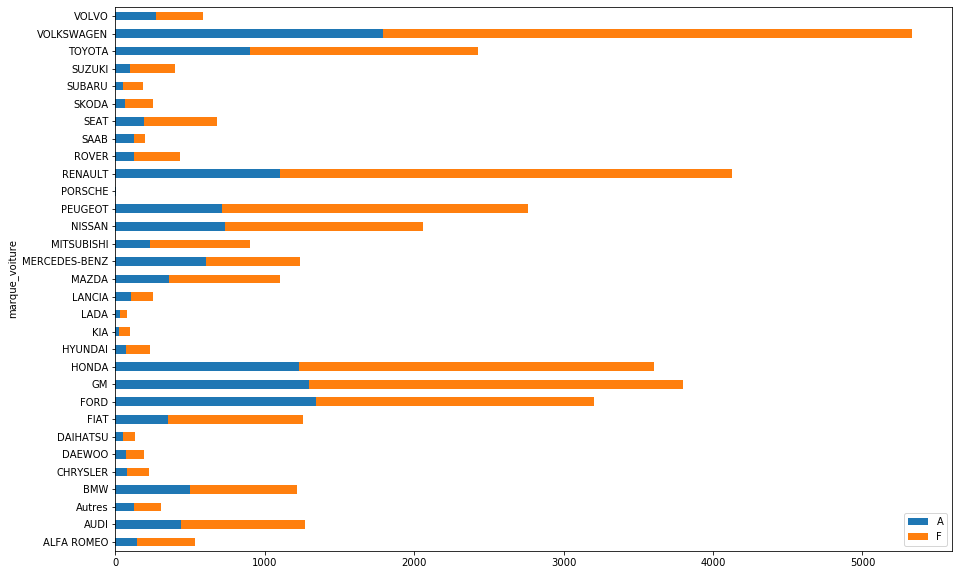

In [33]:
plt.rcParams['figure.figsize'] = [15,10]
datos.plot(kind='barh', stacked = True)
plt.show()

In [23]:
marca = auto.marque_voiture.value_counts()

In [66]:
jobs = auto.type_prof.value_counts()

In [67]:
france = auto[auto.langue == 'F']

In [68]:
aleman = auto[auto.langue == 'A']

In [85]:
f = france.groupby('type_prof').nbsin.sum()

In [86]:
a = aleman.groupby('type_prof').nbsin.sum()

In [80]:
accidente = auto.groupby('type_prof').nbsin.sum()

In [83]:
a = pd.DataFrame([accidente]).T

In [87]:
totale = pd.DataFrame({'aleman':a, 'frances':f})

In [111]:
urb1 = auto[auto.type_territoire=='Urbain']

In [114]:
u1 = urb1.groupby('type_prof').nbsin.sum()

In [115]:
urb2 = auto[auto.type_territoire=='Semi-urbain']
urb3 = auto[auto.type_territoire =='Rural']

In [120]:
u2 = urb2.groupby('type_prof').nbsin.sum()
u3 = urb3.groupby('type_prof').nbsin.sum()

In [121]:
accidente2 = pd.DataFrame({'Urbain':u1,'Semi-urbain':u2,'Rural':u3})

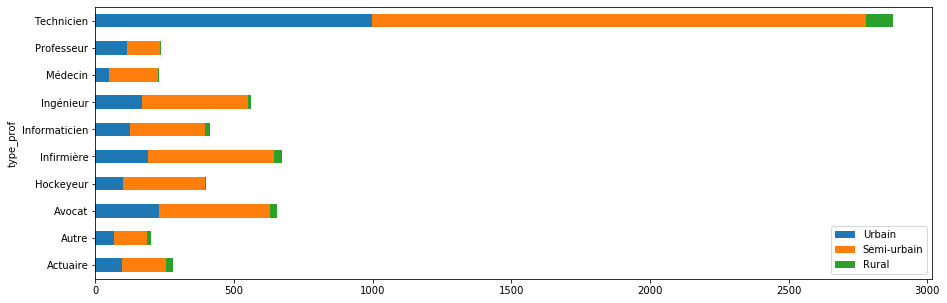

In [123]:
plt.rcParams['figure.figsize'] = [15,5]
accidente2.plot(kind='barh', stacked=True)
plt.show()

In [125]:
accidente2

,Urbain,Semi-urbain,Rural
type_prof,,,
Actuaire,96,159,24
Autre,68,119,14
Avocat,228,401,25
Hockeyeur,101,294,4
Infirmière,189,454,29
Informaticien,126,270,16
Ingénieur,166,384,11
Médecin,49,176,3
Professeur,114,120,1


In [94]:
auto.type_territoire.value_counts()

Semi-urbain    23366
Urbain         14616
Rural           1093
Name: type_territoire, dtype: int64

In [92]:
totale

,aleman,frances
type_prof,,
Actuaire,90,189
Autre,63,138
Avocat,205,449
Hockeyeur,100,299
Infirmière,156,516
Informaticien,112,300
Ingénieur,144,417
Médecin,40,188
Professeur,101,134


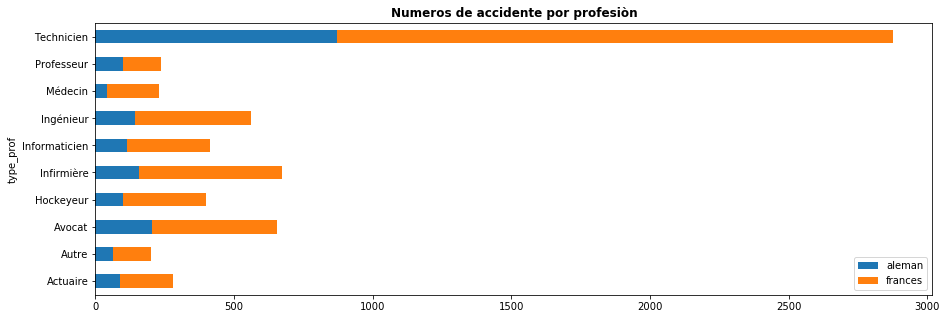

In [91]:
plt.rcParams['figure.figsize'] = [15,5]
totale.plot(kind='barh', stacked = True)
plt.title('Numeros de accidente por profesiòn', fontweight='bold')
plt.show()

In [84]:
a

,nbsin
type_prof,
Actuaire,279
Autre,201
Avocat,654
Hockeyeur,399
Infirmière,672
Informaticien,412
Ingénieur,561
Médecin,228
Professeur,235


In [79]:
auto.groupby('marque_voiture').nbsin.sum()

marque_voiture
ALFA ROMEO       131
AUDI             222
Autres            48
BMW              231
CHRYSLER          41
DAEWOO            27
DAIHATSU          10
FIAT             241
FORD             552
GM               576
HONDA            569
HYUNDAI           42
KIA               23
LADA               5
LANCIA            54
MAZDA            189
MERCEDES-BENZ    200
MITSUBISHI       170
NISSAN           342
PEUGEOT          435
PORSCHE            0
RENAULT          611
ROVER             86
SAAB              37
SEAT             129
SKODA             48
SUBARU            23
SUZUKI            56
TOYOTA           368
VOLKSWAGEN       982
VOLVO             68
Name: nbsin, dtype: int64

In [6]:
df1 = auto.drop(['exposition', 'nbsin'], axis =1)

In [7]:
df2 = pd.get_dummies(df1, drop_first=True)

In [8]:
df2.head()

,cout,age,duree_permis,freq_paiement_mensuel,langue_F,type_prof_Autre,type_prof_Avocat,type_prof_Hockeyeur,type_prof_Infirmière,type_prof_Informaticien,...,marque_voiture_ROVER,marque_voiture_SAAB,marque_voiture_SEAT,marque_voiture_SKODA,marque_voiture_SUBARU,marque_voiture_SUZUKI,marque_voiture_TOYOTA,marque_voiture_VOLKSWAGEN,marque_voiture_VOLVO,sexe_M
numeropol,,,,,,,,,,,,,,,,,,,,,
1,0.00,29,10,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.00,30,11,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,279.58,42,21,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.00,43,22,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0.00,44,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
formula = 'nbsin~cout+age+freq_paiement+sexe+presence_alarme'

In [21]:
model = smf.glm(formula, family=sm.families.Poisson(), data=df)

In [22]:
resultado = model.fit()
print(resultado.summary2())

                Results: Generalized linear model
Model:              GLM              AIC:            36530.2929  
Link Function:      log              BIC:            -388429.7072
Dependent Variable: nbsin            Log-Likelihood: -18259.     
Date:               2020-08-24 23:33 LL-Null:        -18802.     
No. Observations:   39075            Deviance:       24656.      
Df Model:           5                Pearson chi2:   4.10e+04    
Df Residuals:       39069            Scale:          1.0000      
Method:             IRLS                                         
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept        -1.2879   0.0515 -25.0125 0.0000 -1.3888 -1.1869
cout              0.0000   0.0000  41.0812 0.0000  0.0000  0.0000
age              -0.0080   0.0011  -7.4844 0.0000 -0.0101 -0.0059
freq_paiement    -0.2360  

In [49]:
print(resultado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                39075
Model:                            GLM   Df Residuals:                    39023
Model Family:        NegativeBinomial   Df Model:                           51
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17975.
Date:                Fri, 28 Feb 2020   Deviance:                       19347.
Time:                        19:19:32   Pearson chi2:                 3.44e+04
No. Iterations:                    48                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
cout      

In [53]:
expo = auto.exposition.values

In [60]:
e = np.asarray(expo)

In [61]:
len(e)

39075